In [80]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('baraj_seviyesi_tum_yillar_eksiksiz.csv', index_col=0, parse_dates=True) # Assuming the first column is the date index

# Select the target variable
df_target = df[['Baraj_Seviyesi']].copy()

In [81]:


# Create Lag Features (Example: 1, 7, 30, 365 days lag)
lags = [1, 7, 30, 365]
for lag in lags:
    df_target[f'lag_{lag}'] = df_target['Baraj_Seviyesi'].shift(lag)

# Create Time Features
df_target['month'] = df_target.index.month
df_target['dayofyear'] = df_target.index.dayofyear
df_target['year'] = df_target.index.year
# df_target['dayofweek'] = df_target.index.dayofweek # Optional

# Drop rows with NaN values created by lagging
df_processed = df_target.dropna()

# Define Features (X) and Target (y)
features = [col for col in df_processed.columns if col != 'Baraj_Seviyesi']
X = df_processed[features]
y = df_processed['Baraj_Seviyesi']


In [82]:

# Example split: Train up to end of 2023, Test on 2024 onwards
# Adjust the date based on your data's range
split_date_test = '2025-01-01'
# Optional: Define a validation split date if tuning hyperparameters
# split_date_val = '2023-01-01'

X_train = X[X.index < split_date_test]
y_train = y[y.index < split_date_test]
X_test = X[X.index >= split_date_test]
y_test = y[y.index >= split_date_test]

# If using a validation set for tuning:
# X_train_val = X_train[X_train.index < split_date_val]
# y_train_val = y_train[y_train.index < split_date_val]
# X_val = X_train[X_train.index >= split_date_val]
# y_val = y_train[y_train.index >= split_date_val]
# X_train = X_train_val # Redefine training set
# y_train = y_train_val # Redefine training set


In [83]:

# Instantiate the model
rf_model = RandomForestRegressor(n_estimators=100, # Number of trees
                                 random_state=42,
                                 n_jobs=-1, # Use all available CPU cores
                                 max_features='sqrt') # Consider 'sqrt' or 'log2' for potentially better generalization

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete.")


Training Random Forest model...
Training complete.


In [84]:

# Make predictions
y_pred = rf_model.predict(X_test)


Test RMSE: 1.3591
Test MAE: 1.2564
Test MAPE: 0.83%
R-squared: 0.9922
Explained Variance: 0.9897


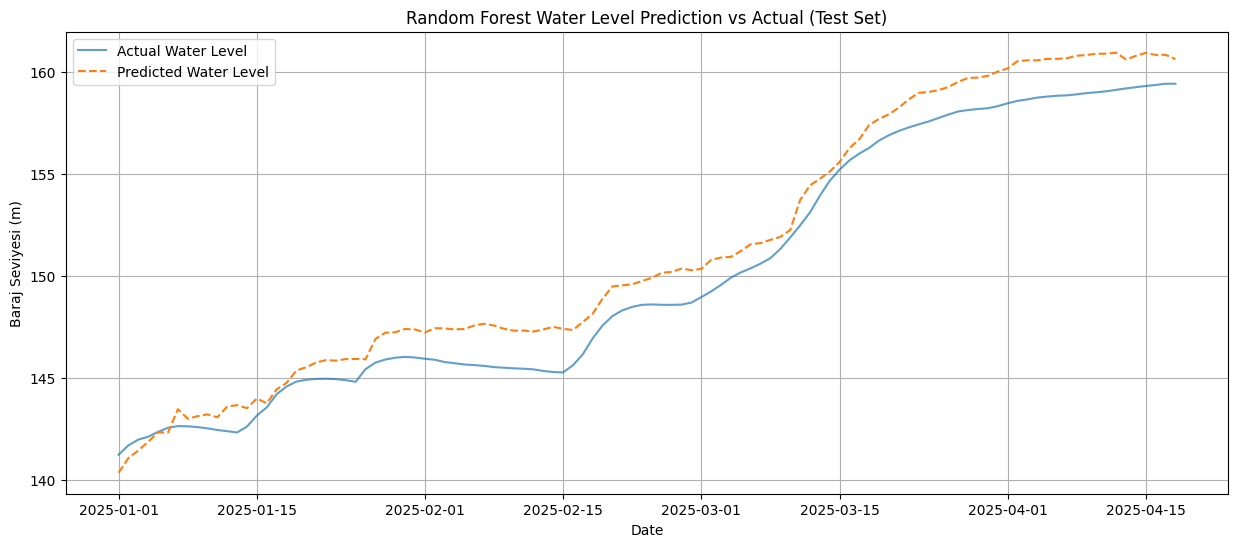

In [85]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = np.corrcoef(y_test, y_pred)[0, 1]**2  # R-squared (coefficient of determination)
explained_variance = 1 - np.var(y_test - y_pred) / np.var(y_test)  # Explained variance

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")


# Visualize predictions vs actuals
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Water Level', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted Water Level', linestyle='--')
plt.title('Random Forest Water Level Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Baraj Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()


In [86]:


# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
     Feature  Importance
0      lag_1    0.375100
1      lag_7    0.311537
2     lag_30    0.128408
5  dayofyear    0.094083
4      month    0.072591
3    lag_365    0.014134
6       year    0.004147
